In [1]:
# Environment setup function
def setup_spark_environment():
    # Install dependencies
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
    !tar xf spark-3.5.4-bin-hadoop3.tgz
    !pip install -q findspark

    # Set environment variables
    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

    # Initialize findspark
    import findspark
    findspark.init()

    # Create Spark session
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

    return spark

# Call setup function
spark = setup_spark_environment()

#Task 3

##Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType, StructType, StructField
from pyspark.ml.linalg import Vectors as MLVectors, VectorUDT  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors
import matplotlib.pyplot as plt
import numpy as np
import random
import time

##CUR Class

In [ ]:
class CUR_Decomposition_Distributed:
    """
    Class implementing CUR decomposition for dimensionality reduction using distributed operations.
    C: Selected columns from original matrix
    U: Connecting matrix
    R: Selected rows from original matrix
    """

    def __init__(self, target_dim=5, seed=42):
        """
        Initialize CUR decomposition.

        Parameters:
        -----------
        target_dim : int
            Target dimensionality after reduction
        seed : int
            Random seed for reproducibility
        """
        self.target_dim = target_dim
        self.seed = seed
        self.column_indices = None
        self.column_probabilities = None
        self.row_indices = None
        self.U_matrix = None

        # Set seed for reproducibility at the worker level
        from pyspark.sql.functions import rand
        self.rand_func = rand(seed)

    def fit(self, data, features_col="features"):
        """
        Fit the CUR decomposition in a distributed manner.

        Parameters:
        -----------
        data : DataFrame
            Spark DataFrame with feature column
        features_col : str
            Name of the column containing feature vectors

        Returns:
        --------
        self
        """
        from pyspark.sql.functions import udf, col, sum as spark_sum, monotonically_increasing_id, lit
        from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
        from pyspark.ml.linalg import Vectors, DenseVector, SparseVector

        start_time = time.time()

        # Step 1: Create a RowMatrix from the features
        vector_rdd = data.select(features_col).rdd.map(lambda row: MLLibVectors.fromML(row[0]))
        mat = RowMatrix(vector_rdd)

        # Get dimensions
        m = mat.numRows()
        n = mat.numCols()
        print(f"Matrix dimensions: {m} rows x {n} columns")

        # Step 2: Compute SVD to get leverage scores
        svd = mat.computeSVD(n, computeU=True)
        s = svd.s
        V = svd.V
        print(f"SVD computation time: {time.time() - start_time:.2f} seconds")

        # Step 3: Calculate column probabilities (leverage scores) in a distributed way
        spark = data.sparkSession

        # Create schema for the V matrix
        v_schema = StructType([StructField(f"v_{i}", DoubleType(), True) for i in range(V.numRows)])

        # Create DataFrame from V matrix rows
        v_rows = []
        for i in range(V.numCols):
            row_values = [float(V.toArray()[j, i]) for j in range(V.numRows)]
            v_rows.append(tuple(row_values))

        v_df = spark.createDataFrame(v_rows, v_schema)

        # Add explicit integer column index from 0 to n-1
        from pyspark.sql.window import Window
        import pyspark.sql.functions as F

        window = Window.orderBy(lit(1))
        v_df = v_df.withColumn("col_idx", F.row_number().over(window) - 1)

        # Compute squared values for each element in a distributed way
        square_exprs = [col(f"v_{i}") * col(f"v_{i}") for i in range(V.numRows)]

        # Calculate sum of squares for each column (leverage scores)
        sum_of_squares_expr = square_exprs[0]
        for expr_item in square_exprs[1:]:
            sum_of_squares_expr = sum_of_squares_expr + expr_item

        v_df = v_df.withColumn("leverage_score", sum_of_squares_expr)

        # Calculate total sum of leverage scores
        total_leverage = v_df.agg(spark_sum("leverage_score")).collect()[0][0]

        # Calculate probabilities
        v_df = v_df.withColumn("probability", col("leverage_score") / total_leverage)

        # Distributed approach to sampling columns based on probability
        v_df = v_df.withColumn("rand_val", self.rand_func)

        # Select columns with highest probability
        selected_cols = v_df.orderBy(col("probability").desc()).limit(self.target_dim)

        # Collect selected column indices (this is a small collection, acceptable)
        self.column_indices = [int(row.col_idx) for row in selected_cols.select("col_idx").collect()]
        self.column_indices = sorted(self.column_indices)

        # Get the probabilities for the selected columns
        selected_probs = selected_cols.select("probability").collect()
        self.column_probabilities = [float(row.probability) for row in selected_probs]

        print(f"Selected columns: {self.column_indices}")
        print(f"With probabilities: {self.column_probabilities}")

        return self

    def transform(self, data, features_col="features"):
        """
        Transform data using CUR decomposition.

        Parameters:
        -----------
        data : DataFrame
            DataFrame to transform
        features_col : str
            Name of the column containing feature vectors

        Returns:
        --------
        DataFrame
            DataFrame with reduced features
        """
        if self.column_indices is None:
            raise ValueError("CUR decomposition not fitted yet.")

        # Make a local copy of column_indices that can be properly serialized
        column_indices_broadcast = self.column_indices

        # Create UDF to extract selected columns from feature vector
        @udf(returnType=VectorUDT())
        def extract_columns(vector):
            if vector is None:
                return None

            features = vector.toArray()
            selected_features = [features[idx] for idx in column_indices_broadcast if idx < len(features)]
            return MLVectors.dense(selected_features)

        # Apply transformation
        result = data.withColumn("features_cur", extract_columns(col(features_col)))

        return result

##Prepare Data

In [55]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess gold price data.
    """
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date")).orderBy("Date")

    # Create lag features using PySpark's distributed APIs
    windowSpec = Window.orderBy("Date")
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", lag("Sell Price", i).over(windowSpec))

    # Drop rows with null values
    df = df.na.drop()
    return df

##Train and evaluate model

In [ ]:
def train_and_evaluate_model_distributed(train_data, test_data, features_col="features", label_col="label", model_name="Model"):
    """
    Train and evaluate a LinearRegression model using distributed operations.
    """
    # Configure and train the Linear Regression model
    lr = LinearRegression(
        featuresCol=features_col,
        labelCol=label_col,
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.5,
        standardization=True,
        tol=1e-12,
        solver="l-bfgs"
    )

    # Train model
    start_time = time.time()
    model = lr.fit(train_data)
    print(f"Training time: {time.time() - start_time:.2f} seconds")

    # Evaluate the model
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=label_col)

    # Make predictions
    train_pred = model.transform(train_data)
    test_pred = model.transform(test_data)
    metrics_dict = {}

    # Generate metrics for visualization (only collecting 4 small values)
    evaluator.setMetricName("rmse")
    train_rmse = evaluator.evaluate(train_pred)
    test_rmse = evaluator.evaluate(test_pred)

    evaluator.setMetricName("r2")
    train_r2 = evaluator.evaluate(train_pred)
    test_r2 = evaluator.evaluate(test_pred)

    # Print metrics
    print(f"{model_name} Training RMSE: {train_rmse:.4f}")
    print(f"{model_name} Test RMSE: {test_rmse:.4f}")
    print(f"{model_name} Training R²: {train_r2:.4f}")
    print(f"{model_name} Test R²: {test_r2:.4f}")
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
    }

##Visualize

In [57]:
def create_comparison_visualization(original_metrics, cur_metrics):
    """
    Create a bar chart comparing original and CUR results.
    """
    labels = ['Training RMSE', 'Test RMSE']
    original_values = [original_metrics['train_rmse'], original_metrics['test_rmse']]
    cur_values = [cur_metrics['train_rmse'], cur_metrics['test_rmse']]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    original_bars = ax.bar(x - width/2, original_values, width, label='Original (10 features)')
    cur_bars = ax.bar(x + width/2, cur_values, width, label='CUR-reduced (5 features)')

    # Add labels and formatting
    ax.set_ylabel('RMSE Loss')
    ax.set_title('Comparison of Loss Between Original and CUR-reduced Models')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

    add_labels(original_bars)
    add_labels(cur_bars)

    plt.tight_layout()
    plt.show()

##Main


Loading and preprocessing data...
Dataset sample:
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|      Date|Buy Price|Sell Price|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2009-08-11|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-12|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-13|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-14|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-15|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
only showing top 5 rows


Creating feature vectors...

Splitting data...
Training set size: 39

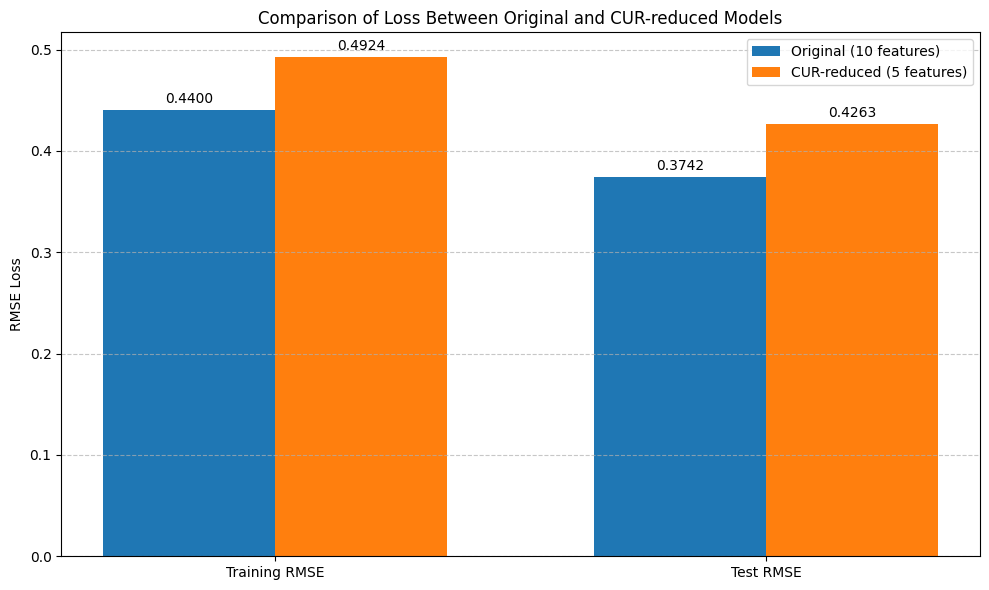


Total runtime: 27.50 seconds


In [ ]:
def main():
    try:
        start_time = time.time()

        # Load and preprocess data
        print("\nLoading and preprocessing data...")
        df = load_and_preprocess_data("gold_prices.csv")
        print("Dataset sample:")
        df.show(5)

        # Define feature columns
        feature_cols = [f"lag_{i}" for i in range(1, 11)]

        # Create feature vector for original data
        print("\nCreating feature vectors...")
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        vector_df = assembler.transform(df).select(
            "Date", "features", col("Sell Price").alias("label"), *feature_cols)

        # Cache dataframe for performance
        vector_df.cache()

        # Split data into training and test sets
        print("\nSplitting data...")
        train_data, test_data = vector_df.randomSplit([0.7, 0.3], seed=42)
        print(f"Training set size: {train_data.count()}")
        print(f"Test set size: {test_data.count()}")

        # Train and evaluate original model
        print("\n=== Original Model (10 features) ===")
        original_metrics = train_and_evaluate_model_distributed(
            train_data, test_data, "features", "label", "Original Model")

        # Apply CUR decomposition
        print("\n=== Applying CUR Decomposition (Distributed) ===")
        cur = CUR_Decomposition_Distributed(target_dim=5, seed=42)
        cur.fit(vector_df)

        # Transform data using CUR
        print("\nTransforming data with CUR...")
        cur_train_data = cur.transform(train_data)
        cur_test_data = cur.transform(test_data)

        # Show sample of transformed data
        print("\nSample of CUR-transformed data:")
        cur_train_data.select("features_cur").show(2, truncate=False)

        # Train and evaluate CUR-reduced model
        print("\n=== CUR-Reduced Model (5 features) ===")
        cur_metrics = train_and_evaluate_model_distributed(
            cur_train_data, cur_test_data, "features_cur", "label", "CUR-reduced Model")

        # Create comparison visualization
        print("\nCreating comparison visualization...")
        create_comparison_visualization(original_metrics, cur_metrics)

        # Print overall runtime
        total_time = time.time() - start_time
        print(f"\nTotal runtime: {total_time:.2f} seconds")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        if 'vector_df' in locals():
            vector_df.unpersist()
        spark.stop()

if __name__ == "__main__":
    main()